In [1]:
import gzip
import pickle

import sys, os
from os import path

import jax.numpy as np
import numpy as onp
from functools import partial
from jax import vmap
from jax.lax import scan
from jax.lax import cond
from jax import random
from jax import jit
from jax import jacrev
from jax.lax import stop_gradient
import matplotlib.pylab as plt
import matplotlib as mpl
from sklearn import manifold, datasets
import seaborn as sns
from tsne_jax import tsne
import scipy

from jax.config import config
config.update("jax_debug_nans", True)
JAX_ENABLE_X64=True

from tueplots import figsizes, fonts, bundles
from tueplots import cycler
from tueplots.constants import markers
from tueplots.constants.color import palettes

# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 150})

# Definitions

In [2]:
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return onp.ma.masked_array(onp.interp(value, x, y))

def load_data(n_samples=None):
    with gzip.open(path.join("examples/data/mnist", "mnist.pkl.gz"), "rb") as f:
        data = pickle.load(f)

    x, y = data["pca_50"], data["labels"]

    if n_samples is not None:
        indices = onp.random.choice(
            list(range(x.shape[0])), n_samples, replace=False
        )
        x, y = x[indices], y[indices]

    return x, y

def compute_importances_per_sample(jacobian):
    jacobian_sum_per_sample = []
    jacobian_sum = np.sum(np.abs(jacobian), axis=0)
    for i in range(n):
        sum_for_sample = []
        for j in range(p):
            sum_for_sample.append(jacobian_sum[j*n+i])
        jacobian_sum_per_sample.append(sum(sum_for_sample))
    return jacobian_sum_per_sample

def HdiffGreaterTrue(*betas):
    beta, betamax = betas
    return beta*2

def HdiffGreaterFalse(*betas):
    beta, betamax = betas
    return (beta+betamax)/2

def HdiffSmallerTrue(*betas):
    beta, betamin = betas
    return beta/2

def HdiffSmallerFalse(*betas):
    beta, betamin = betas
    return (beta+betamin)/2

def HdiffGreater(*betas):
    beta, betamin, betamax = betas
    betamin = beta
    beta = cond((np.logical_or(betamax == np.inf, betamax == -np.inf)), HdiffGreaterTrue, HdiffGreaterFalse, *(beta, betamax))
    return beta, betamin, betamax

def HdiffSmaller(*betas):
    beta, betamin, betamax = betas
    betamax = beta
    beta = cond(np.logical_or(betamin == np.inf, betamin == -np.inf), HdiffSmallerTrue, HdiffSmallerFalse, *(beta, betamin))
    return beta, betamin, betamax

def HdiffGreaterTolerance(*betas):
    beta, betamin, betamax, Hdiff = betas
    beta, betamin, betamax = cond(Hdiff > 0, HdiffGreater, HdiffSmaller, *(beta, betamin, betamax))
    return beta, betamin, betamax, Hdiff


def pca(X: np.ndarray, no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """
    print("Preprocessing the data using PCA...")
    #(n, d) = X.shape
    X = X - np.mean(X, axis=0)
    u, s, vh = np.linalg.svd(X, full_matrices=False, compute_uv=True, hermitian=False)
    #l = (s ** 2 / (d))[0:no_dims]
    M = vh[0:no_dims, :]
    Y = np.dot(X, M.T)
    return Y

def logSoftmax(x):
    """Compute softmax for vector x."""
    max_x = np.max(x)
    exp_x = np.exp(x - max_x)
    sum_exp_x = np.sum(exp_x)
    log_sum_exp_x = np.log(sum_exp_x)
    max_plus_log_sum_exp_x = max_x + log_sum_exp_x
    log_probs = x - max_plus_log_sum_exp_x

    # Recover probs
    exp_log_probs = np.exp(log_probs)
    sum_log_probs = np.sum(exp_log_probs)
    probs = exp_log_probs / sum_log_probs
    return probs


def Hbeta(D: np.ndarray, beta=1.0):
    """
    Compute the log2(perplexity)=Entropy and the P-row (P_i) for a specific value of the
        precision=1/(sigma**2) (beta) of a Gaussian distribution. D: vector of squared Euclidean distances (without i)
    :param D: vector of length d, squared Euclidean distances to all other datapoints (except itself)
    :param beta: precision = beta = 1/sigma**2
    :return: H: log2(Entropy), P: computed probabilites
    """
    # TODO: exchange by softmax as described by https://nlml.github.io/in-raw-numpy/in-raw-numpy-t-sne/
    P = np.exp(-D * beta)     # numerator of p j|i
    sumP = np.sum(P, axis=None)    # denominator of p j|i --> normalization factor
    new_P = logSoftmax(-D * beta)
    sumP += 1e-8
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    return H, new_P

def binarySearch(res, el, Di, logU):
    print('Entered binary search function')
    Hdiff, thisP, beta, betamin, betamax = res
    Hdiffbool = np.abs(Hdiff) < 1e-5
    beta, betamin, betamax, Hdiff = cond(np.abs(Hdiff) < 1e-5, lambda a, b, c, d: (a, b, c, d), HdiffGreaterTolerance, *(beta, betamin, betamax, Hdiff))

    (H, thisP) = Hbeta(Di, beta)
    Hdiff = H - logU
    return (Hdiff, thisP, beta, betamin, betamax), el

def x2p_inner(Di: np.ndarray, iterator, beta, betamin, betamax, perplexity=30, tol=1e-5):
    """
    binary search for precision for Pi such that it matches the perplexity defined by the user
    :param Di: vector of length d-1, squared Euclidean distances to all other datapoints (except itself)
    :param beta: precision = beta = 1/sigma**2
    :return: final probabilites p j|i
    """
    # Compute the Gaussian kernel and entropy for the current precision
    logU = np.log(perplexity)
    H, thisP = Hbeta(Di, beta)
    Hdiff = H - logU

    print('Starting binary search')
    binarySearch_func = partial(binarySearch, Di=Di, logU=logU)

    # Note: the following binary Search for suitable precisions (betas) will be repeated 50 times and does not include the threshold value
    (Hdiff, thisP, beta, betamin, betamax), el = scan(binarySearch_func, init=(Hdiff, thisP, beta, betamin, betamax), xs=None, length=50)    # Set the final row of P
    thisP = np.insert(thisP, iterator, 0)
    return thisP

def x2p(X: np.ndarray, tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values (high-dim space) in such a way that each
        conditional Gaussian has the same perplexity.
    """
    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    D = np.reshape(np.delete(D, np.array([i for i in range(0, D.shape[0]**2, (D.shape[0]+1))])), (n , n - 1 ))
    beta = np.ones(n)      # precisions (1/sigma**2)
    betamin = np.full(n, -np.inf)
    betamax = np.full(n, np.inf)
    P = vmap(partial(x2p_inner, perplexity=perplexity, tol=tol))(D, np.arange(n), beta=beta, betamin=betamin, betamax=betamax)
    return P


def optimizeY(res, el, P, initial_momentum=0.5, final_momentum=0.8, eta=500, min_gain=0.01, exaggeration=4.):
    Y, iY, gains, i = res
    n, d = Y.shape

    # Compute pairwise affinities
    sum_Y = np.sum(np.square(Y), 1)
    num = -2. * np.dot(Y, Y.T)  # numerator
    num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
    num = num.at[np.diag_indices_from(num)].set(0.)     # numerator
    Q = num / np.sum(num)
    Q = np.maximum(Q, 1e-12)


    # Compute gradient
    PQ = P - Q
    PQ_exp = np.expand_dims(PQ, 2)  # NxNx1
    Y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)  # nx1x2 - 1xnx2= # NxNx2
    num_exp = np.expand_dims(num, 2)    # NxNx1
    Y_diffs_wt = Y_diffs * num_exp
    grad = np.sum((PQ_exp * Y_diffs_wt), axis=1) # Nx2

    # Update Y
    momentum = cond(i<250, lambda: initial_momentum, lambda: final_momentum)
    # this business with "gains" is the bar-delta-bar heuristic to accelerate gradient descent
    # code could be simplified by just omitting it
    #inc = iY * grad > 0
    #dec = iY * grad < 0
    #gains = np.where((iY * grad > 0), gains+0.2, gains)
    #gains = np.where((iY * grad < 0), gains*0.8, gains)
    gains = np.clip(gains, min_gain, np.inf)

    iY = momentum * iY - eta * (gains * grad)
    Y = Y + iY

    Y = Y - np.mean(Y, axis=0)
    P = cond(i==100, lambda x: x/exaggeration, lambda x:x, P)
    i += 1
    return ((Y, iY, gains, i), 1.0)

def optimizeYforBackprob(res, el, P, initial_momentum=0.8, final_momentum=0.5, eta=500, min_gain=0.01):
    Y, iY, gains, i = res
    n, d = Y.shape

    # Compute pairwise affinities
    sum_Y = stop_gradient(np.sum(np.square(Y), 1))
    num = stop_gradient(-2. * np.dot(Y, Y.T))  # numerator
    num = stop_gradient(1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y)))
    num = stop_gradient(num.at[np.diag_indices_from(num)].set(0.))     # numerator
    Q = stop_gradient(num / np.sum(num))
    Q = stop_gradient(np.maximum(Q, 1e-12))


    # Compute gradient
    PQ = P - Q
    PQ_exp = np.expand_dims(PQ, 2)  # NxNx1
    Y_diffs = stop_gradient(np.expand_dims(Y, 1) - np.expand_dims(Y, 0))  # nx1x2 - 1xnx2= # NxNx2
    num_exp = np.expand_dims(num, 2)    # NxNx1
    Y_diffs_wt = stop_gradient(Y_diffs * num_exp)
    grad = np.sum((PQ_exp * Y_diffs_wt), axis=1) # Nx2

    # Update Y
    momentum = cond(i<20, lambda: initial_momentum, lambda: final_momentum)
    # this business with "gains" is the bar-delta-bar heuristic to accelerate gradient descent
    # code could be simplified by just omitting it
    # inc = iY * grad > 0
    # dec = iY * grad < 0
    # gains = np.where((iY * grad > 0), gains+0.2, gains)
    # gains = np.where((iY * grad < 0), gains*0.8, gains)
    gains = np.clip(gains, min_gain, np.inf)

    iY = momentum * iY - eta * (gains * grad)
    Y = Y + iY

    Y = Y - np.mean(Y, axis=0)
    P = cond(i==250, lambda x: x/12., lambda x:x, P)
    i += 1
    return ((Y, iY, gains, i), 1.0)

def tsne(X: np.ndarray, no_dims=2, initial_dims=50, perplexity=30.0, learning_rate=500, max_iter = 1000, exaggeration=4., key=42):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    #X = pca(X, initial_dims)
    (n, d) = X.shape
    key = random.PRNGKey(key)

    initial_momentum = 0.8
    final_momentum = 0.5
    eta = learning_rate   # Initial learning rate
    min_gain = 0.01
    # Initialize solution
    #if init is not None:
    #    Y = init
    #else:
    #    Y = random.normal(key, shape=(n, no_dims))
    Y = random.normal(key, shape=(n, no_dims))
    dY = np.zeros((n, no_dims))
    #Y_t1 = np.zeros((n, no_dims))
    #Y_t2 = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)    # I don't know if the computed P is correct np.sum(P, axis=0) is not 1 everywhere
    P = (P + np.transpose(P))

    P = P / np.sum(P)      # Why don't we devide by 2N as described everywhere?
    P = P * exaggeration  # early exaggeration
    P = np.maximum(P, 1e-12)

    # for debugging
    #for i in range(1000):
    #  ((P, Y, dY, iY, gains, i), j) = optimizeY((P, Y, dY, iY, gains, i), el=1, initial_momentum = initial_momentum, final_momentum = final_momentum, eta = eta, min_gain = min_gain)


    # jit-compiled version
    optimizeY_func = partial(optimizeY, P=P, initial_momentum = initial_momentum, final_momentum = final_momentum, eta = eta, min_gain = min_gain, exaggeration = exaggeration)
    ((Y, iY, gains, i), el) = scan(optimizeY_func, init=(Y, iY, gains, 0), xs=None, length=max_iter)  # Set the final row of P
    return Y


# Test dataset

In [28]:
x, y = load_data(n_samples=400)
x = np.array(x)

Computing pairwise distances...
Starting binary search
Entered binary search function


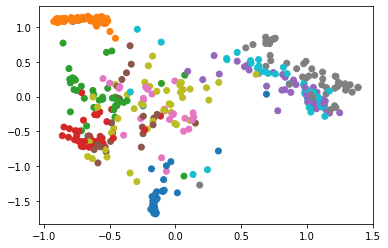

In [29]:
tsne_func = partial(tsne, no_dims=2, initial_dims=50, perplexity=20.0, learning_rate=200, max_iter=1000, exaggeration=4., key=42)
Y = tsne_func(x)
#tsne_jacobian = jacrev(tsne_func)(x)
plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap='tab10')

# Animate Jacobian MNIST

In [3]:
tsne_plots = []
n, p = (100, 50)
X, y = load_data(n_samples=n)
tsne_func = partial(tsne, no_dims=2, initial_dims=50, perplexity=20.0, learning_rate=200, exaggeration=4., key=42)

plt.rcParams.update(cycler.cycler(color=palettes.tue_plot))
statistics = []
for i in range(1, 101):
    print(i)
    jacobian = jacrev(tsne_func)(X, max_iter=i)
    jacobian_reshape = np.reshape(np.reshape(jacobian, (2, n, n*p), order='F'),
                                       (n*2,
                                       n*p))
    statistics.append([np.mean(np.abs(jacobian_reshape)), np.std(np.abs(jacobian_reshape)), np.median(np.abs(jacobian_reshape))])

1
Computing pairwise distances...
Starting binary search
Entered binary search function
2
Computing pairwise distances...
Starting binary search
Entered binary search function
3
Computing pairwise distances...
Starting binary search
Entered binary search function
4
Computing pairwise distances...
Starting binary search
Entered binary search function
5
Computing pairwise distances...
Starting binary search
Entered binary search function
6
Computing pairwise distances...
Starting binary search
Entered binary search function
7
Computing pairwise distances...
Starting binary search
Entered binary search function
8
Computing pairwise distances...
Starting binary search
Entered binary search function
9
Computing pairwise distances...
Starting binary search
Entered binary search function
10
Computing pairwise distances...
Starting binary search
Entered binary search function
11
Computing pairwise distances...
Starting binary search
Entered binary search function
12
Computing pairwise distance

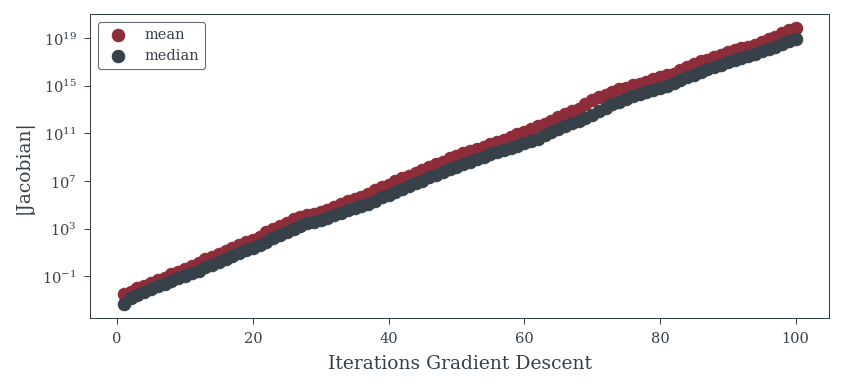

In [13]:
statistic_array = np.array(statistics)
plt.rcParams.update(cycler.cycler(color=palettes.tue_plot))
with plt.rc_context(bundles.beamer_moml()):
    fig, ax = plt.subplots()
    ax.scatter([i for i in range(1, 101)], statistic_array[:, 0], label='mean')
    ax.scatter([i for i in range(1, 101)], statistic_array[:, 2], label='median')
    ax.set_yscale('log')
    ax.set_xlabel('Iterations Gradient Descent')
    ax.set_ylabel('|Jacobian|')
    plt.legend()
    plt.savefig('benchmark_results/jacobians.pdf')

In [7]:
ani = animation.ArtistAnimation(fig, tsne_plots, interval=500, blit=True,
               repeat_delay=5000)
HTML(ani.to_html5_video())

In [5]:
n, p = (100, 40)
X, y = datasets.make_blobs(n, p, cluster_std=0.3)
print(X.shape)
tsne_func = partial(tsne, no_dims=2, initial_dims=50, perplexity=20.0, learning_rate=400, max_iter=1)
#Y = tsne_func(X)
# plt.scatter(Y[:, 0], Y[:, 1], c=y)
tsne_jacobian = jacrev(tsne_func)(X)
#print('mean derivative', np.mean(tsne_jacobian))
#print('median derivative', np.median(tsne_jacobian))
#print('Jacobian shape', tsne_jacobian.shape)
#jacobian_reshape = np.reshape(np.reshape(tsne_jacobian, (2, n, n*p), order='F'),
#                                        (n*2,
#                                        n*p))
#vmin=onp.min(jacobian_reshape)
#vmax=onp.max(jacobian_reshape)
#f = plt.figure(figsize=(30, 10))
#ax = sns.heatmap(jacobian_reshape, cmap="coolwarm", norm=(MidpointNormalize(midpoint=0, vmin=vmin, vmax=vmax)))
#ax.set_xlabel('Input points X vectorized')
#ax.set_ylabel('Output points Y vectorized')
#ax.set_title('Jacobian of tsne w.r.t input')

(100, 40)
Computing pairwise distances...
Starting binary search
Entered binary search function
[[[[-4.15223688e-01 -1.78366140e-01  2.79650360e-01 ...  7.39663661e-01
    -6.90433264e-01  1.92521870e+00]
   [-1.74534563e-02  6.85934797e-02 -2.51098692e-01 ... -8.89281780e-02
     2.52766125e-02  4.41587642e-02]
   [ 1.87856131e-09  9.37582456e-10 -5.77974291e-09 ...  1.58923985e-09
    -6.22762286e-10 -1.98567918e-09]
   ...
   [-1.79974623e-02 -1.83683187e-02  1.14248134e-04 ... -3.51987742e-02
    -5.51498123e-03  2.03437805e-02]
   [-1.12187237e-09  2.53081112e-09  1.29844580e-10 ...  3.99227318e-09
    -4.60768490e-09  4.32834923e-09]
   [-3.24699823e-10 -1.45181400e-09 -9.71952296e-10 ...  1.47959334e-09
    -1.00665343e-09 -1.12380771e-09]]

  [[ 1.20334327e-02  7.00717270e-01  7.12546051e-01 ...  1.42997205e-02
     1.24143505e+00 -5.44900596e-01]
   [-1.75872687e-02 -3.66574898e-02  3.57043818e-02 ...  2.05952786e-02
    -3.78010832e-02  3.49127688e-02]
   [-1.81633197e-09 -4.

# Animation 

In [9]:
%matplotlib inline

0
Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function
1
Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function
2
Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function
3
Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function
4
Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function
5
Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting b

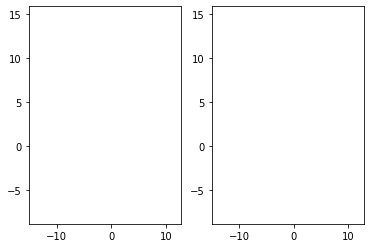

In [12]:
import matplotlib.animation as animation
from IPython.display import HTML
tsne_plots = []
tsne_plots_importance = []
jacobians = []
n, p = (80, 100)
X, y = datasets.make_blobs(n, p, cluster_std=0.1)
tsne_func = partial(tsne, no_dims=2, initial_dims=50, perplexity=20.0, learning_rate=400)
fig, (ax1, ax2) = plt.subplots(1, 2)
for i in range(10):
    print(i)
    Y = tsne_func(X=X, max_iter=i)
    jacobian = jacrev(tsne_func)(X, max_iter=i)
    jacobian_reshape = np.reshape(np.reshape(jacobian, (2, n, n*p), order='F'),
                                       (n*2,
                                       n*p))
    importances = compute_importances_per_sample(jacobian_reshape)
    im = ax1.scatter(Y[:, 0], Y[:, 1], c=y, animated=True)
    im2 = ax2.scatter(Y[:, 0], Y[:, 1], c=importances, animated=True)
    tsne_plots.append([im, im2])
ani = animation.ArtistAnimation(fig, tsne_plots, interval=300, blit=True,
               repeat_delay=5000)

In [13]:
ani = animation.ArtistAnimation(fig, tsne_plots, interval=500, blit=True,
               repeat_delay=5000)
HTML(ani.to_html5_video())

In [2]:
n, p = (10, 2)
Y = onp.random.random((n, p))
Y1 = Y - np.mean(Y, axis=0)
Y2 = Y - np.tile(np.mean(Y, 0), (n, 1))

In [3]:
print(Y1, Y2)

[[-0.3756323  -0.29080272]
 [-0.22582018  0.29579067]
 [-0.01686245  0.45125914]
 [ 0.13505924 -0.48799264]
 [ 0.21825421 -0.02644563]
 [ 0.1576016   0.40949655]
 [ 0.01832253  0.03520095]
 [-0.03407758 -0.48460275]
 [ 0.10875303 -0.17897156]
 [ 0.01440197  0.27706766]] [[-0.3756323  -0.29080272]
 [-0.22582018  0.29579067]
 [-0.01686245  0.45125914]
 [ 0.13505924 -0.48799264]
 [ 0.21825421 -0.02644563]
 [ 0.1576016   0.40949655]
 [ 0.01832253  0.03520095]
 [-0.03407758 -0.48460275]
 [ 0.10875303 -0.17897156]
 [ 0.01440197  0.27706766]]
